In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "8"
DEVICE='cuda:0'

In [2]:
import sys
sys.path.append(os.path.realpath('../../'))

In [9]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

model_name = "deepset/roberta-large-squad2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name, cache_dir="/mount/arbeitsdaten/asr-2/vaethdk/resources/weights/").to(DEVICE)

In [10]:
nlp = pipeline('question-answering', model=model_name, tokenizer=model_name, device=DEVICE, cache_dir="/mount/arbeitsdaten/asr-2/vaethdk/resources/weights/")



In [17]:
QA_input = {
    'question': 'What do we need?',
    'context': 'Computers are neccessary for daily life.'
}
res = nlp(QA_input)

In [18]:
res

{'score': 0.9104044437408447, 'start': 0, 'end': 9, 'answer': 'Computers'}

In [20]:
QA_input = {
    'question': 'Who is John?',
    'context': 'Computers are neccessary for daily life.'
}
res = nlp(QA_input)
print(res)

{'score': 2.9505565990461946e-08, 'start': 39, 'end': 40, 'answer': '.'}


In [36]:
QA_input = {
    'question': 'Where does John live?',
    'context': 'Computers are neccessary for daily life.'
}
res = nlp(QA_input)
print(res)

{'score': 1.678999828058636e-09, 'start': 39, 'end': 40, 'answer': '.'}


In [24]:
QA_input = {
    'question': 'How much does Nutella cost in the US?',
    'context': 'Computers are neccessary for daily life.'
}
res = nlp(QA_input)
print(res)

{'score': 2.3946718386014254e-08, 'start': 14, 'end': 40, 'answer': 'neccessary for daily life.'}


In [25]:
from data.dataset import GraphDataset, ReimburseGraphDataset, DataAugmentationLevel, DialogNode, NodeType

In [60]:
human_data_train = ReimburseGraphDataset('en/reimburse/train_graph.json', 'en/reimburse/train_answers.json', False, augmentation=DataAugmentationLevel.NONE, resource_dir="../../resources/")
human_data_test = ReimburseGraphDataset('en/reimburse/test_graph.json', 'en/reimburse/test_answers.json', False, augmentation=DataAugmentationLevel.NONE, resource_dir="../../resources/")
generated_data_train_v1 = ReimburseGraphDataset('en/reimburse/train_graph.json', 'en/reimburse/train_answers.json', False, augmentation=DataAugmentationLevel.ARTIFICIAL_ONLY, augmentation_path="en/reimburse/generated/train_questions_v1.json", resource_dir="../../resources/")
generated_data_train_v1_ling = ReimburseGraphDataset('en/reimburse/train_graph.json', 'en/reimburse/train_answers.json', False, augmentation=DataAugmentationLevel.ARTIFICIAL_ONLY, augmentation_path="en/reimburse/generated/train_questions_v1_ling.json", resource_dir="../../resources/")
generated_data_train_v2 = ReimburseGraphDataset('en/reimburse/train_graph.json', 'en/reimburse/train_answers.json', False, augmentation=DataAugmentationLevel.ARTIFICIAL_ONLY, augmentation_path="en/reimburse/generated/train_questions_v2.json", resource_dir="../../resources/")
generated_data_train_v2_ling = ReimburseGraphDataset('en/reimburse/train_graph.json', 'en/reimburse/train_answers.json', False, augmentation=DataAugmentationLevel.ARTIFICIAL_ONLY, augmentation_path="en/reimburse/generated/train_questions_v2_ling.json", resource_dir="../../resources/")
generated_data_train_v3 = ReimburseGraphDataset('en/reimburse/train_graph.json', 'en/reimburse/train_answers.json', False, augmentation=DataAugmentationLevel.ARTIFICIAL_ONLY, augmentation_path="en/reimburse/generated/train_questions_v3.json", resource_dir="../../resources/")
generated_data_train_v3_ling = ReimburseGraphDataset('en/reimburse/train_graph.json', 'en/reimburse/train_answers.json', False, augmentation=DataAugmentationLevel.ARTIFICIAL_ONLY, augmentation_path="en/reimburse/generated/train_questions_v3_ling.json", resource_dir="../../resources/")

- not using synonyms
===== Dataset Statistics =====
- files:  en/reimburse/train_graph.json en/reimburse/train_answers.json
- synonyms: False
- depth: 20  - degree: 13
- answers: 73
- questions: 279
- loaded original data: True
- loaded generated data: False
- not using synonyms
===== Dataset Statistics =====
- files:  en/reimburse/test_graph.json en/reimburse/test_answers.json
- synonyms: False
- depth: 20  - degree: 13
- answers: 73
- questions: 173
- loaded original data: True
- loaded generated data: False
- Loading questions from  ../../resources/en/reimburse/generated/train_questions_v1.json
- not using synonyms
===== Dataset Statistics =====
- files:  en/reimburse/train_graph.json en/reimburse/train_answers.json
- synonyms: False
- depth: 20  - degree: 13
- answers: 73
- questions: 800
- loaded original data: False
- loaded generated data: True
- Loading questions from  ../../resources/en/reimburse/generated/train_questions_v1_ling.json
- not using synonyms
===== Dataset Statist

In [69]:
datasets = {
    "Human Train": human_data_train,
    "Human Test": human_data_test,
    "Generated V1": generated_data_train_v1,
    "Generated V1 Ling": generated_data_train_v1_ling,
    "Generated V2": generated_data_train_v2,
    "Generated V2 Ling": generated_data_train_v2_ling,
    "Generated V3": generated_data_train_v3,
    "Generated V3 Ling": generated_data_train_v3_ling,
}

In [77]:
from tqdm.auto import tqdm
import torch

scores = {}

for dataset_name in datasets:
    dataset = datasets[dataset_name]
    scores[dataset_name] = []
    print(dataset_name, "#questions:", len(dataset.question_list))

    for question in tqdm(dataset.question_list):
        if question.parent.node_type == NodeType.INFO:
            # check if question is answerable by node text
            qa_pair = {
                'question': question.text,
                'context':  question.parent.text
            }
            res = nlp(qa_pair)
            score = res['score']
            scores[dataset_name].append(qa_pair | {"score": score})

    torch.save(scores[dataset_name], f"qa_analysis/{dataset_name}_qa_scores.pt")

Human Train #questions: 279


  0%|          | 0/279 [00:00<?, ?it/s]/mount/arbeitsdaten/asr-2/vaethdk/virtualenvs/cts_en/lib64/python3.10/site-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 279/279 [00:05<00:00, 50.09it/s]


Human Test #questions: 173


100%|██████████| 173/173 [00:03<00:00, 49.55it/s]


Generated V1 #questions: 800


100%|██████████| 800/800 [00:17<00:00, 46.16it/s]


Generated V1 Ling #questions: 3681


100%|██████████| 3681/3681 [01:17<00:00, 47.39it/s]


Generated V2 #questions: 800


100%|██████████| 800/800 [00:17<00:00, 46.32it/s]


Generated V2 Ling #questions: 3062


100%|██████████| 3062/3062 [01:04<00:00, 47.70it/s]


Generated V3 #questions: 416


100%|██████████| 416/416 [00:08<00:00, 47.61it/s]


Generated V3 Ling #questions: 2134


100%|██████████| 2134/2134 [00:46<00:00, 46.20it/s]


In [ ]:
import seaborn as sns
import pandas

In [78]:
ds_scores = []
for dataset_name in datasets:
    data = torch.load(f"qa_analysis/{dataset_name}_qa_scores.pt")
    scores = [item['score'] for item in data]
    print(dataset_name, "#questions:", len(dataset.question_list), "#scores:", len(scores))
    for score in scores:
        ds_scores.append({"source": dataset_name, "score": score})
df = pandas.DataFrame(ds_scores)

Human Train #questions: 2134 #scores: 269
Human Test #questions: 2134 #scores: 167
Generated V1 #questions: 2134 #scores: 800
Generated V1 Ling #questions: 2134 #scores: 3681
Generated V2 #questions: 2134 #scores: 800
Generated V2 Ling #questions: 2134 #scores: 3062
Generated V3 #questions: 2134 #scores: 416
Generated V3 Ling #questions: 2134 #scores: 2134


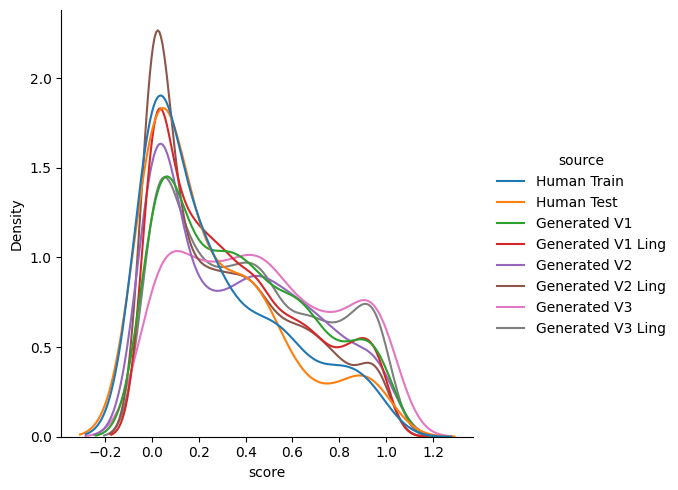

In [83]:
sns.displot(df.reset_index(drop=True), x="score", kind="kde", hue='source', common_norm=False)

In [96]:
# Extract some bad example qa pairs
bad_questions = {}

for dataset_name in datasets:
    data = torch.load(f"qa_analysis/{dataset_name}_qa_scores.pt")
    print(dataset_name, "#questions:", len(dataset.question_list), "#scores:", len(scores))
    bad_questions[dataset_name] = []
    for item in data:
        if item["score"] < 0.0001:
            bad_questions[dataset_name].append(item)

        # if len(bad_questions[dataset_name]) > 5:
        #     break

Human Train #questions: 2134 #scores: 2134
Human Test #questions: 2134 #scores: 2134
Generated V1 #questions: 2134 #scores: 2134
Generated V1 Ling #questions: 2134 #scores: 2134
Generated V2 #questions: 2134 #scores: 2134
Generated V2 Ling #questions: 2134 #scores: 2134
Generated V3 #questions: 2134 #scores: 2134
Generated V3 Ling #questions: 2134 #scores: 2134


In [97]:
bad_questions['Human Train']

[{'question': 'Can I book first class?',
  'context': 'Booking a "Business"  class ticket is allowed on flights which last more than 10 uninterrupted hours. Otherwise, only the cheapest flight class is reimbursable. A seat reservation is not reimbursable.',
  'score': 1.056544761013356e-06},
 {'question': 'Can I book regional transportation?',
  'context': "You can book train tickets yourself (through the DB website, at their counter / ticket machine) or through the university's partner travel agency (Tel. +123456789). You can find contact information for the partner travel agency here.",
  'score': 3.0357628929778002e-05},
 {'question': 'What is counted as an ancillary cost?',
  'context': 'Incidental costs are, e.g.,: Insurances Visa fees \n Conference meals \n Parking fees \n Oversized baggage fees \n Conference fees \n Credit card fees \n Cloakroom fees \n Entrance costs \n Postage costs \n Vaccinations',
  'score': 2.633099484228296e-06},
 {'question': 'What trainings are offered 

In [99]:
bad_questions['Generated V3']

[{'question': 'What is the cheapest flight class that is reimbursable for flights under 10 uninterrupted hours?',
  'context': 'Booking a "Business"  class ticket is allowed on flights which last more than 10 uninterrupted hours. Otherwise, only the cheapest flight class is reimbursable. A seat reservation is not reimbursable.',
  'score': 6.661098450422287e-05},
 {'question': 'Can I skip asking my supervisor for an intracity trip?',
  'context': "Verbal permission is required from your supervisor for an intracity business trip. Please don't forget to get this. Written permission is not necessary",
  'score': 6.588458927581087e-05},
 {'question': 'What is the role of RKI in providing travel warnings and restrictions related to COVID-19?',
  'context': 'Please check the current COVID-19 travel warnings travel restrictions from the foreign ministry and the RKI. Business trips to high risk areas or virus variation areas are not generally not allowed. In In extreme cases, authorization can